<a href="https://colab.research.google.com/github/newmantic/LSTM/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np

class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights
        self.Wf = np.random.randn(hidden_size, input_size + hidden_size) * 0.01  # Forget gate
        self.bf = np.zeros((hidden_size, 1))

        self.Wi = np.random.randn(hidden_size, input_size + hidden_size) * 0.01  # Input gate
        self.bi = np.zeros((hidden_size, 1))

        self.Wc = np.random.randn(hidden_size, input_size + hidden_size) * 0.01  # Cell gate
        self.bc = np.zeros((hidden_size, 1))

        self.Wo = np.random.randn(hidden_size, input_size + hidden_size) * 0.01  # Output gate
        self.bo = np.zeros((hidden_size, 1))

        self.Wy = np.random.randn(output_size, hidden_size) * 0.01  # Hidden to output
        self.by = np.zeros((output_size, 1))

    def forward(self, inputs):
        h_prev = np.zeros((self.hidden_size, 1))
        c_prev = np.zeros((self.hidden_size, 1))
        hs, cs, ys = [], [], []

        for x in inputs:
            x = np.reshape(x, (-1, 1))
            concat = np.concatenate((h_prev, x), axis=0)

            ft = self.sigmoid(np.dot(self.Wf, concat) + self.bf)  # Forget gate
            it = self.sigmoid(np.dot(self.Wi, concat) + self.bi)  # Input gate
            ct_bar = np.tanh(np.dot(self.Wc, concat) + self.bc)  # Cell gate
            c_t = ft * c_prev + it * ct_bar  # New cell state
            ot = self.sigmoid(np.dot(self.Wo, concat) + self.bo)  # Output gate
            h_t = ot * np.tanh(c_t)  # New hidden state

            y_t = np.dot(self.Wy, h_t) + self.by  # Output

            hs.append(h_t)
            cs.append(c_t)
            ys.append(y_t)

            h_prev = h_t
            c_prev = c_t

        return ys, hs, cs

    def backward(self, inputs, hs, cs, ys, targets, learning_rate=0.001):
        dWf, dWi, dWc, dWo, dWy = np.zeros_like(self.Wf), np.zeros_like(self.Wi), np.zeros_like(self.Wc), np.zeros_like(self.Wo), np.zeros_like(self.Wy)
        dbf, dbi, dbc, dbo, dby = np.zeros_like(self.bf), np.zeros_like(self.bi), np.zeros_like(self.bc), np.zeros_like(self.bo), np.zeros_like(self.by)
        dh_next = np.zeros_like(hs[0])
        dc_next = np.zeros_like(cs[0])

        for t in reversed(range(len(inputs))):
            dy = ys[t] - targets[t]
            dWy += np.dot(dy, hs[t].T)
            dby += dy

            dh = np.dot(self.Wy.T, dy) + dh_next  # Gradient of hidden state
            do = dh * np.tanh(cs[t])
            do = do * self.sigmoid_derivative(np.dot(self.Wo, np.concatenate((hs[t-1] if t > 0 else np.zeros_like(hs[0]), inputs[t].reshape(-1, 1)), axis=0)) + self.bo)
            dWo += np.dot(do, np.concatenate((hs[t-1] if t > 0 else np.zeros_like(hs[0]), inputs[t].reshape(-1, 1)), axis=0).T)
            dbo += do

            dc = dh * np.tanh(cs[t]) * self.tanh_derivative(cs[t]) + dc_next
            dc_bar = dc * self.sigmoid(np.dot(self.Wi, np.concatenate((hs[t-1] if t > 0 else np.zeros_like(hs[0]), inputs[t].reshape(-1, 1)), axis=0)) + self.bi)
            dc_bar = dc_bar * self.tanh_derivative(np.dot(self.Wc, np.concatenate((hs[t-1] if t > 0 else np.zeros_like(hs[0]), inputs[t].reshape(-1, 1)), axis=0)) + self.bc)
            dWc += np.dot(dc_bar, np.concatenate((hs[t-1] if t > 0 else np.zeros_like(hs[0]), inputs[t].reshape(-1, 1)), axis=0).T)
            dbc += dc_bar

            di = dc * np.tanh(np.dot(self.Wc, np.concatenate((hs[t-1] if t > 0 else np.zeros_like(hs[0]), inputs[t].reshape(-1, 1)), axis=0)) + self.bc)
            di = di * self.sigmoid_derivative(np.dot(self.Wi, np.concatenate((hs[t-1] if t > 0 else np.zeros_like(hs[0]), inputs[t].reshape(-1, 1)), axis=0)) + self.bi)
            dWi += np.dot(di, np.concatenate((hs[t-1] if t > 0 else np.zeros_like(hs[0]), inputs[t].reshape(-1, 1)), axis=0).T)
            dbi += di

            df = dc * (cs[t-1] if t > 0 else np.zeros_like(cs[0]))
            df = df * self.sigmoid_derivative(np.dot(self.Wf, np.concatenate((hs[t-1] if t > 0 else np.zeros_like(hs[0]), inputs[t].reshape(-1, 1)), axis=0)) + self.bf)
            dWf += np.dot(df, np.concatenate((hs[t-1] if t > 0 else np.zeros_like(hs[0]), inputs[t].reshape(-1, 1)), axis=0).T)
            dbf += df

            dh_next = np.dot(self.Wf[:, :self.hidden_size].T, df) + np.dot(self.Wi[:, :self.hidden_size].T, di) + np.dot(self.Wc[:, :self.hidden_size].T, dc_bar) + np.dot(self.Wo[:, :self.hidden_size].T, do)
            dc_next = dc * self.sigmoid(np.dot(self.Wf, np.concatenate((hs[t-1] if t > 0 else np.zeros_like(hs[0]), inputs[t].reshape(-1, 1)), axis=0)) + self.bf)

        for dparam in [dWf, dWi, dWc, dWo, dWy, dbf, dbi, dbc, dbo, dby]:
            np.clip(dparam, -5, 5, out=dparam)

        # Update weights and biases
        self.Wf -= learning_rate * dWf
        self.Wi -= learning_rate * dWi
        self.Wc -= learning_rate * dWc
        self.Wo -= learning_rate * dWo
        self.Wy -= learning_rate * dWy
        self.bf -= learning_rate * dbf
        self.bi -= learning_rate * dbi
        self.bc -= learning_rate * dbc
        self.bo -= learning_rate * dbo
        self.by -= learning_rate * dby

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def train(self, inputs, targets, epochs=100, learning_rate=0.001):
        for epoch in range(epochs):
            ys, hs, cs = self.forward(inputs)
            self.backward(inputs, hs, cs, ys, targets, learning_rate=learning_rate)
            if epoch % 10 == 0:
                loss = np.sum((np.array(ys) - np.array(targets)) ** 2)
                print(f'Epoch {epoch}, Loss: {loss:.4f}')


Epoch 0, Loss: 435.9686
Epoch 10, Loss: 435.9065
Epoch 20, Loss: 435.9065
Epoch 30, Loss: 435.9065
Epoch 40, Loss: 435.9065
Epoch 50, Loss: 435.9065
Epoch 60, Loss: 435.9065
Epoch 70, Loss: 435.9065
Epoch 80, Loss: 435.9065
Epoch 90, Loss: 435.9065


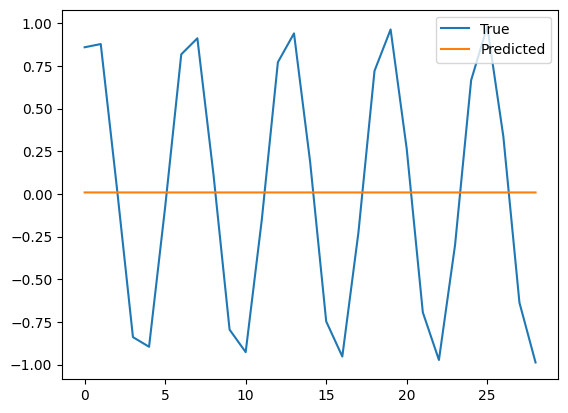

In [22]:
import matplotlib.pyplot as plt

# Generate a simple sine wave sequence
def generate_data(seq_length=20):
    x = np.linspace(0, seq_length, seq_length)
    y = np.sin(x)
    return y[:-1], y[1:]  # input sequence and target sequence

# Initialize the LSTM
input_size = 1
hidden_size = 10
output_size = 1

lstm = LSTM(input_size, hidden_size, output_size)

# Generate training data
inputs, targets = generate_data(seq_length=30)
inputs = [np.array([i]) for i in inputs]
targets = [np.array([t]) for t in targets]

# Train the LSTM
lstm.train(inputs, targets, epochs=100, learning_rate=0.01)

# Generate predictions
preds, _, _ = lstm.forward(inputs)

# Plot the results
plt.plot(range(len(targets)), [t[0] for t in targets], label='True')
plt.plot(range(len(preds)), [p[0][0] for p in preds], label='Predicted')
plt.legend()
plt.show()